In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values, find_dotenv
import os
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import iip_dataclean
import importlib
importlib.reload(iip_dataclean)
from iip_dataclean import iip_dataclean, filter_data_heatmap

# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

# set path using the dictionary key for which one you want
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '\\'
path_imfdata = os.path.abspath(config["IMFDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

plt.rcParams.update({'font.size': 12})

In [2]:
# some previously collected data
# note: 'gdp' is nominal gdp in usd
portfoliodata = pd.read_pickle( path_cleandata + "PortfolioData_interestrates_wICIO.pkl")
portfoliodata = portfoliodata[['iso3', 'Date', 'year', 'gdp', 'spot', 'fwd1', 'policyrate', 'shortterm']]

# country codes
imf_codes = pd.read_csv(path_rawdata + "Country_iso_codes.csv")

# iip data
iip_usd = pd.read_csv(path_imfdata + 'BOP_data_USD.csv', low_memory=False)
iip_euro = pd.read_csv(path_imfdata + 'BOP_data_EURO.csv', low_memory=False)
iip_home = pd.read_csv(path_imfdata + 'BOP_data_DOMESTIC.csv', low_memory=False)

iip_usd_long = iip_dataclean(iip_usd)
iip_euro_long = iip_dataclean(iip_euro)
iip_home_long = iip_dataclean(iip_home)

In [3]:
# cpis data (plus a LOT of data cleaning steps)
cpis = pd.read_csv(path_imfdata + 'CPIS_data.csv', low_memory=False)

# add iso3 codes in order to merge data
iso3_map = imf_codes.set_index('IMF').to_dict()['iso3']
cpis['iso3_o']= cpis['Country Code'].map(iso3_map)
cpis['iso3_c']= cpis['Counterpart Country Code'].map(iso3_map)

# fill euro value
cpis.loc[cpis['Country Name'] == 'Euro Area', 'iso3_o'] = 'EUR'
cpis.loc[cpis['Counterpart Country Name'] == 'Euro Area', 'iso3_c'] = 'EUR'

# drop unused columns
cpis = cpis.drop(['Country Name', 'Country Code', 'Counterpart Country Name', 'Counterpart Country Code', 
                  'Counterpart Sector Name', 'Counterpart Sector Code', 
                  'Sector Name', 'Sector Code', 'Attribute', 'Unnamed: 67'], axis=1)
# these are columns that just show a duplicate of whatever the annual value is so they can just be dropped
cpis = cpis.drop(list(cpis.filter(regex = 'S2')), axis = 1)
# drop any unmatched IMF codes
cpis = cpis.loc[(cpis['iso3_c'].notnull()) & (cpis['iso3_o'].notnull())]

# Specify the columns to keep as identifiers
id_vars = ['Indicator Name', 'Indicator Code', 'iso3_o', 'iso3_c']

# Use the melt function to convert the DataFrame to long format
cpis_long = pd.melt(cpis, id_vars=id_vars, var_name='date', value_name='value')

# remove the weird strings by just changing them to nan
cpis_long.loc[cpis_long['value'] == 'C', 'value'] = np.nan
cpis_long.loc[cpis_long['value'] == '-', 'value'] = np.nan
# i'm considering zeros as nans as well just based on how the zeros are distributed
cpis_long.loc[cpis_long['value'] == '0', 'value'] = np.nan
# change value column to numeric
cpis_long['value'] = pd.to_numeric(cpis_long['value'])

# for some reason the values in each country pair and time period show up across two rows so i need to squish them down
cpis_long = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_o', 'iso3_c', 'date']).sum(min_count=1).reset_index()
cpis_long = cpis_long.fillna(value=np.nan)

# make two cpis dataframes (grouping by both sets of countries)
cpis_grouped_o = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_o', 'date'], as_index=False)['value'].sum(min_count=1)
cpis_grouped_o.rename(columns={'iso3_o': 'iso3'}, inplace=True)
cpis_grouped_c = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_c', 'date'], as_index=False)['value'].sum(min_count=1)
cpis_grouped_o.rename(columns={'iso3_c': 'iso3'}, inplace=True)

Data availability:

IIP data:
- IA_BP6_USD: Assets, Total, US Dollars
- IA_BP6_EUR: Assets, Total, Euros
- IA_BP6_XDC: Assets, Total, National Currency
- IL_BP6_USD: Liabilities, Total, US Dollars
- IL_BP6_EUR: Liabilities, Total, Euros
- IL_BP6_XDC: Liabilities, Total, National Currency

CPIS data:
- I_A_T_T_T_BP6_USD: Assets, Total Investment, BPM6, US Dollars, grouped by country
- I_A_T_T_T_BP6_USD: Assets, Total Investment, BPM6, US Dollars, grouped by counterpart country
- I_L_T_T_T_BP6_USD: Liabilities, Total Investment, BPM6, US Dollars, grouped by country
- I_L_T_T_T_BP6_USD: Liabilities, Total Investment, BPM6, US Dollars, grouped by counterpart country


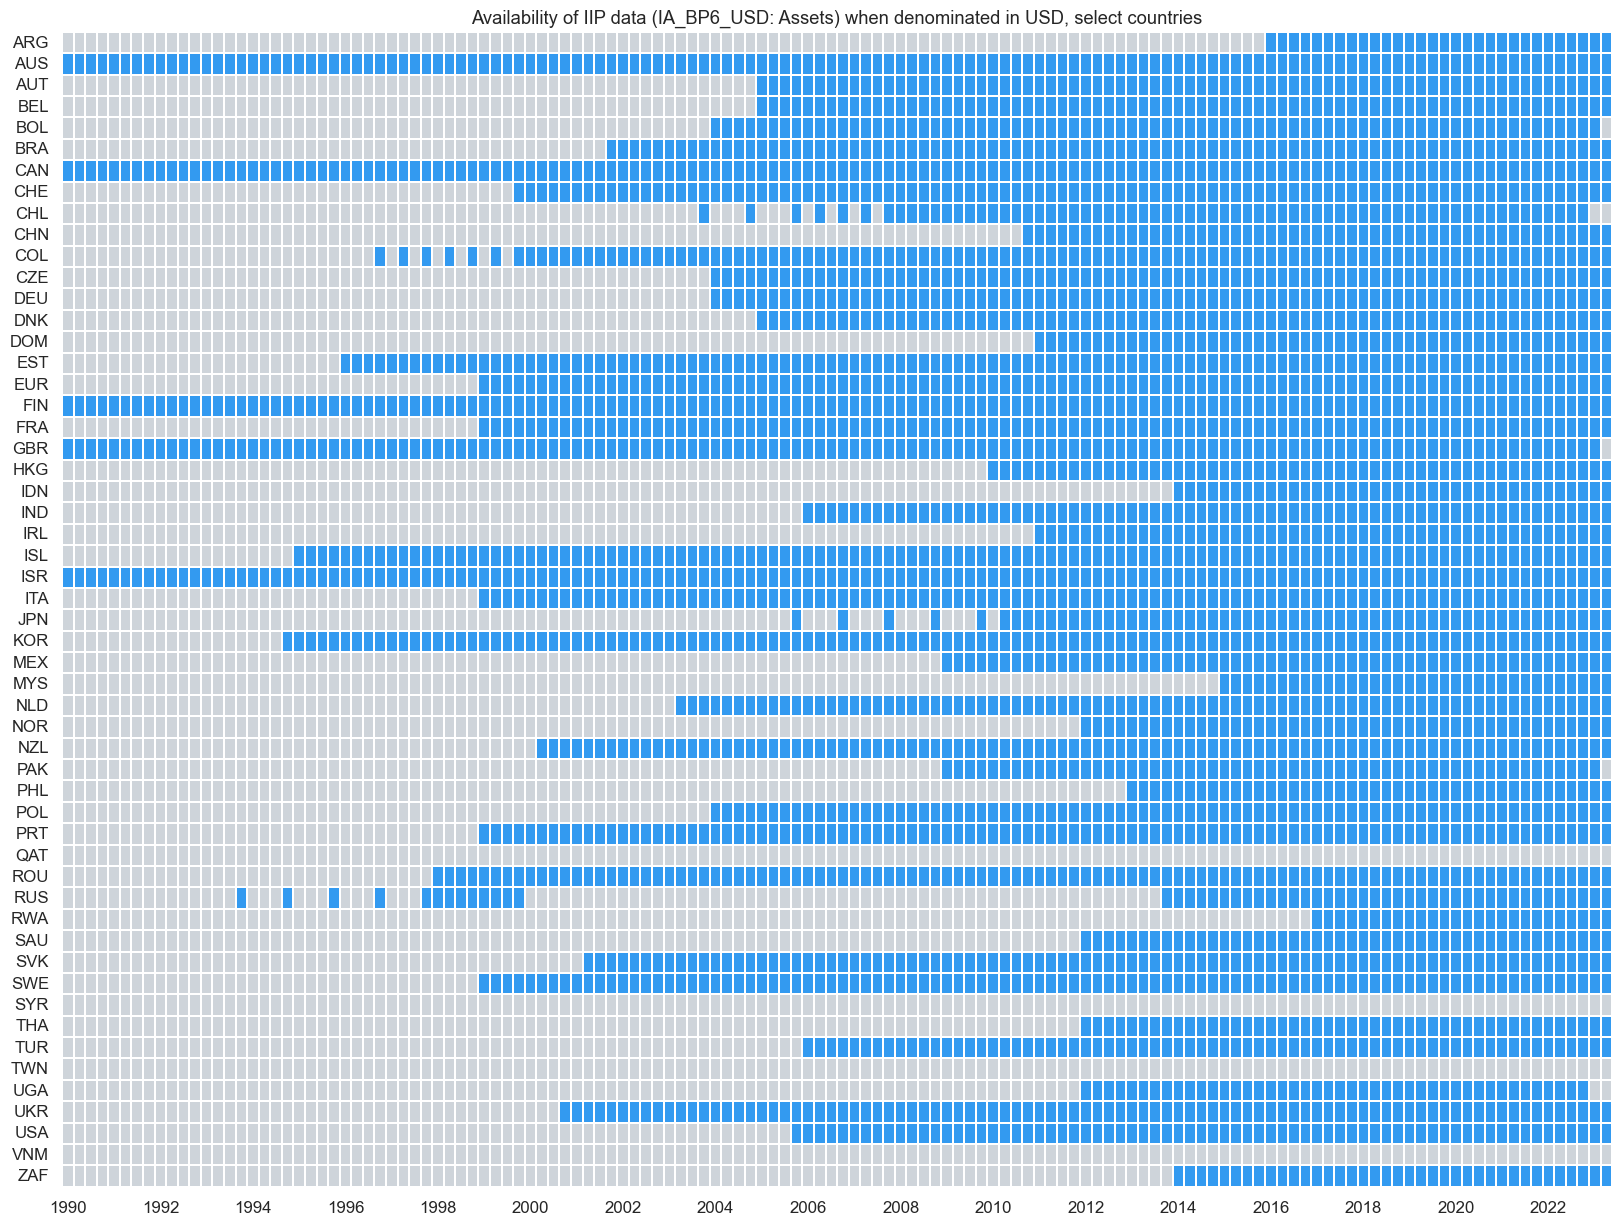

,iso3,date,value
5,AUS,1990-01-31,8.503002e+10
6,ARG,1990-01-31,NaN
9,AUT,1990-01-31,NaN
10,BEL,1990-01-31,NaN
14,BOL,1990-01-31,NaN
...,...,...,...
18219,SYR,2014-07-31,NaN
18220,SYR,2020-01-31,NaN
18221,SYR,1996-04-30,NaN
18222,SYR,2019-10-31,NaN


In [17]:
# one usage (the others are already saved)
filter_data_heatmap(iip_usd_long, 'IA_BP6_USD')

In [5]:
# create dataframe with start and end dates of risk off periods

startdates = [dt.datetime(1997,6,30), dt.datetime(2007,12,31), dt.datetime(2009,10,30), dt.datetime(2013,6,30), dt.datetime(2016,6,30), dt.datetime(2020,3,31), dt.datetime(2020,3,31)]
enddates = [dt.datetime(1997,12,31), dt.datetime(2009,6,30), dt.datetime(2010,12,31), dt.datetime(2013,12,31), dt.datetime(2016,10,31), dt.datetime(2020,3,31), dt.datetime(2021,3,31)]
colour = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'purple']
event = ['1997 Asia Crisis', '2008 Financial Crisis', '2010 Euro Sovereign Debt Crisis', '2013 Taper Tantrum', 'Brexit referendum', 'Brexit', 'COVID-19']

riskoff_dates = pd.DataFrame({'start': startdates, 'end': enddates, 'colour': colour, 'event': event})

a.	Using either the CPIS data (aggregated to the country level) or the International Investment Position data, can you see if the countries with the largest asset positions are those with the lowest interest rates (i.e. US, Japan, Switzerland, Germany)? Can you see what Australia and New Zealand’s Asset positions look like – are they different to these countries materially? Do you see the same patterns if we divide by GDP? Are the patters strongest for gross assets? Net assets? Equity only? Bonds only?

In [6]:
# creating a purely by-country dataset (this is the most general thing to start with)

previousdata = portfoliodata[(portfoliodata['Date'] >= dt.datetime(1990,1,31)) & (portfoliodata['Date'] <= dt.datetime(2023,4,30))][['iso3', 'gdp', 'shortterm']].groupby('iso3').mean()

assetsgross = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IA_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()
liabilities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IL_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()

assetsgross_equities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IAPE_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()
assetsgross_securities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IAPD_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()
liabilities_equities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'ILPE_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()
liabilities_securities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'ILPD_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').mean()

item_a1 = pd.merge(left=previousdata, right=assetsgross, how='inner', on='iso3').dropna().rename(columns={'value': 'asset positions (gross)'})
item_a1 = pd.merge(left=item_a1, right=liabilities, how='inner', on='iso3').dropna().rename(columns={'value': 'liabilities'})
item_a1 = pd.merge(left=item_a1, right=assetsgross_equities, how='inner', on='iso3').dropna().rename(columns={'value': 'asset positions (equity, gross)'})
item_a1 = pd.merge(left=item_a1, right=assetsgross_securities, how='inner', on='iso3').dropna().rename(columns={'value': 'asset positions (debt securities, gross)'})
item_a1 = pd.merge(left=item_a1, right=liabilities_equities, how='inner', on='iso3').dropna().rename(columns={'value': 'liabilities (equity)'})
item_a1 = pd.merge(left=item_a1, right=liabilities_securities, how='inner', on='iso3').dropna().rename(columns={'value': 'liabilities (debt securities)'})

item_a1['asset positions (net)'] = item_a1['asset positions (gross)'] - item_a1['liabilities']
item_a1['asset positions (equity, net)'] = item_a1['asset positions (equity, gross)'] - item_a1['liabilities (equity)']
item_a1['asset positions (debt securities, net)'] = item_a1['asset positions (debt securities, gross)'] - item_a1['liabilities (debt securities)']

item_a1['asset positions (gross) over nominal GDP'] = item_a1['asset positions (gross)']/item_a1['gdp']
item_a1['asset positions (equity, gross) over nominal GDP'] = item_a1['asset positions (equity, gross)']/item_a1['gdp']
item_a1['asset positions (debt securities, gross) over nominal GDP'] = item_a1['asset positions (debt securities, gross)']/item_a1['gdp']


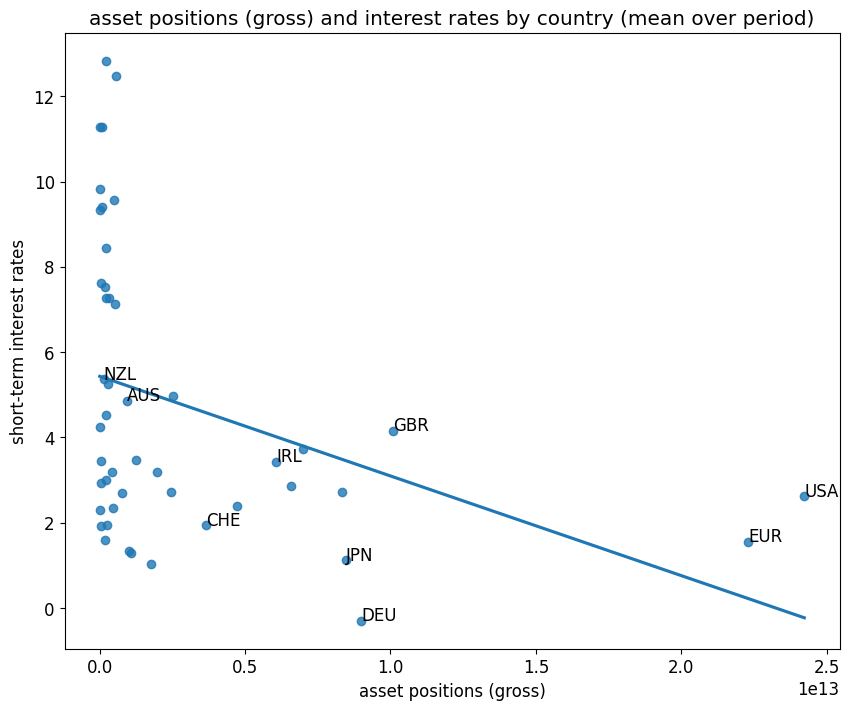

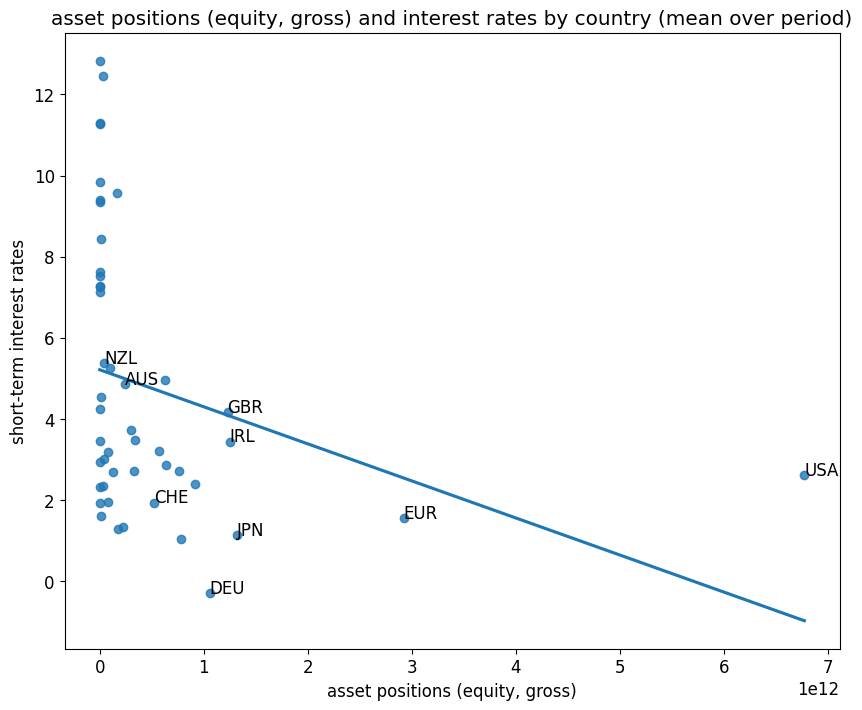

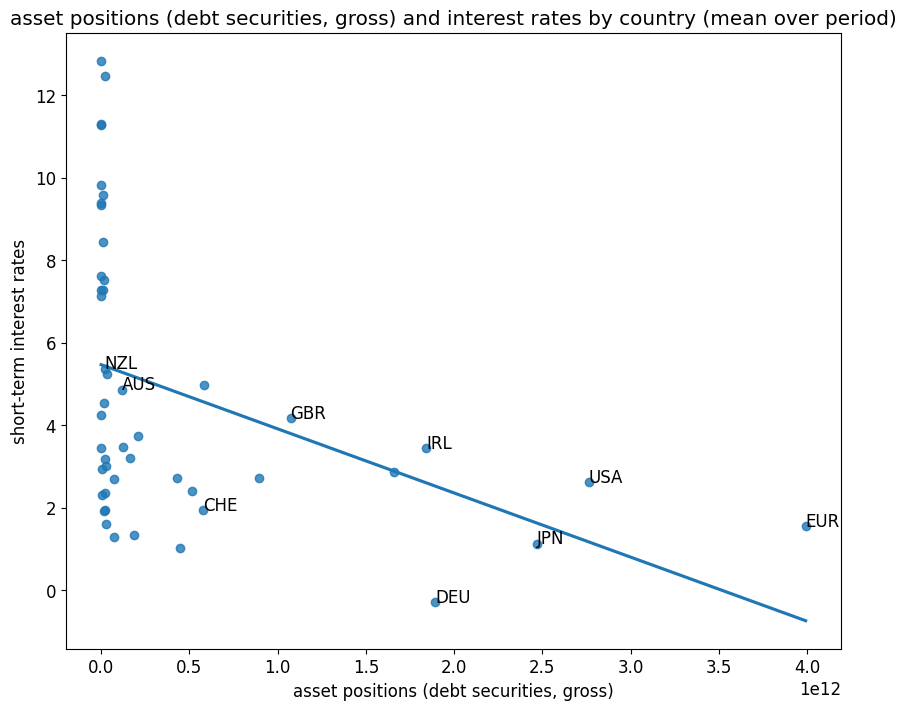

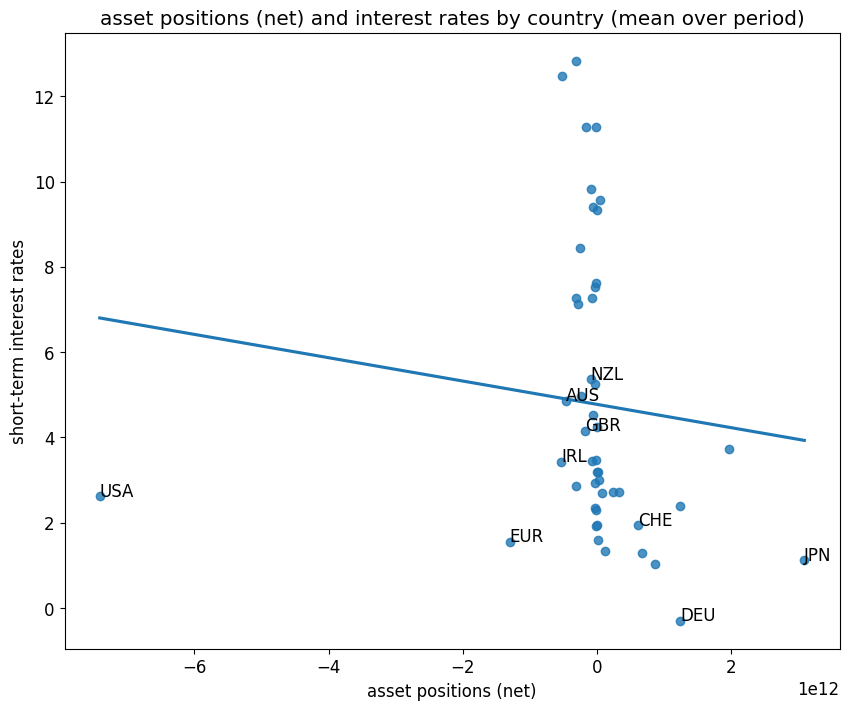

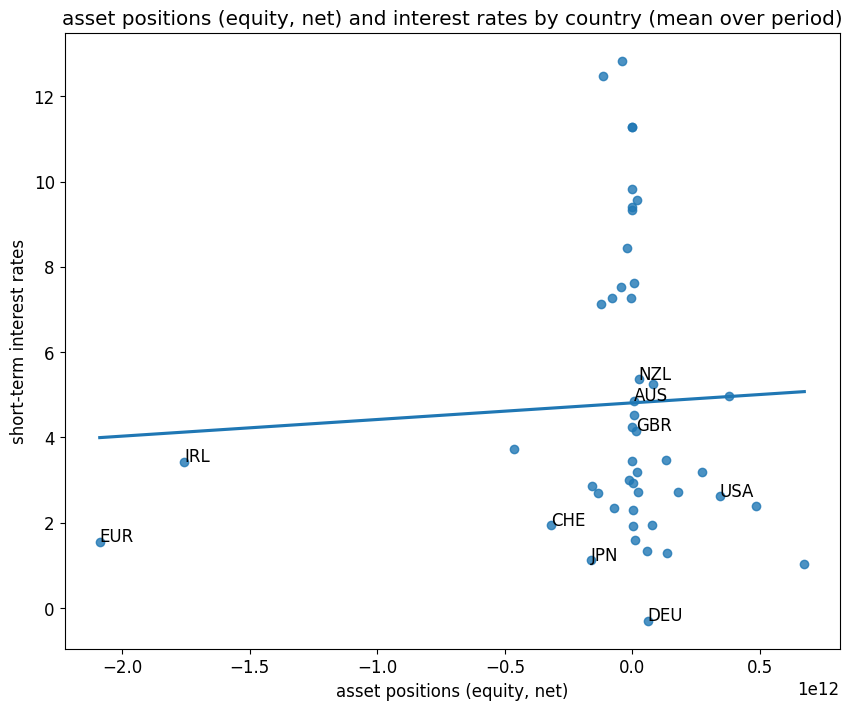

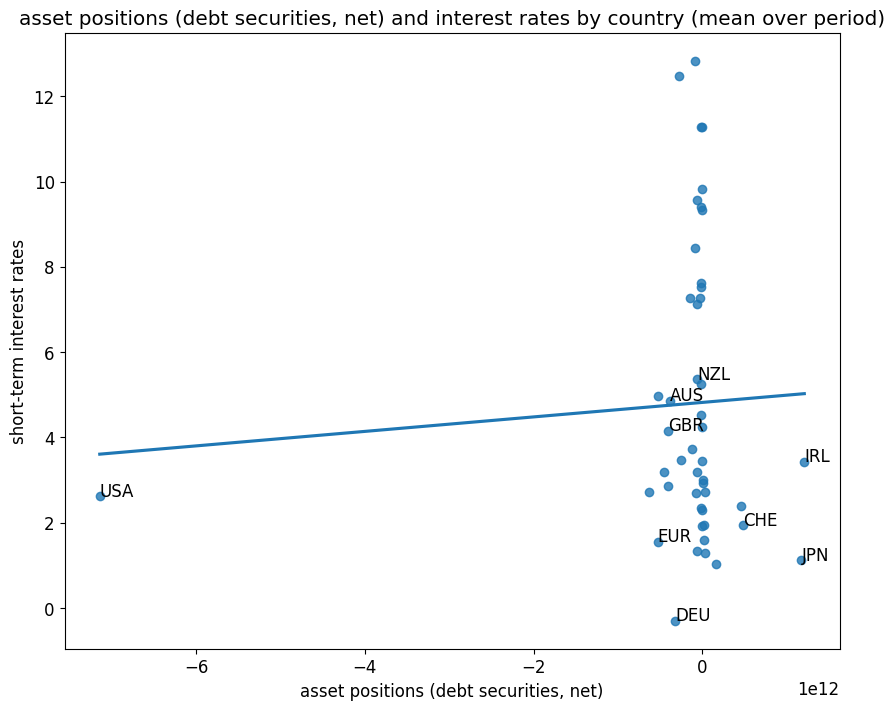

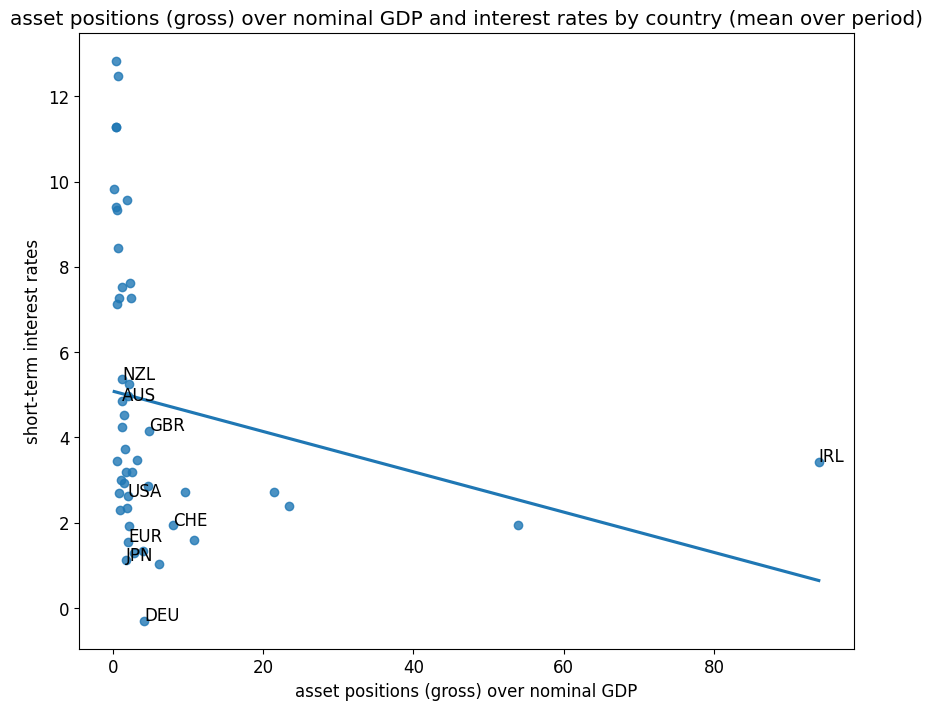

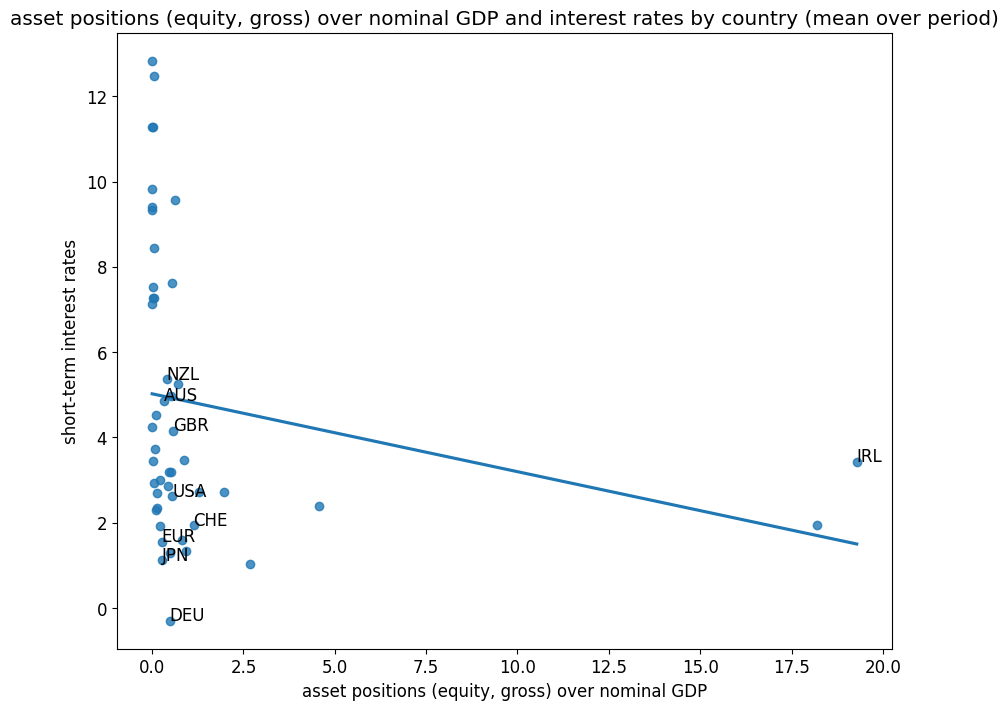

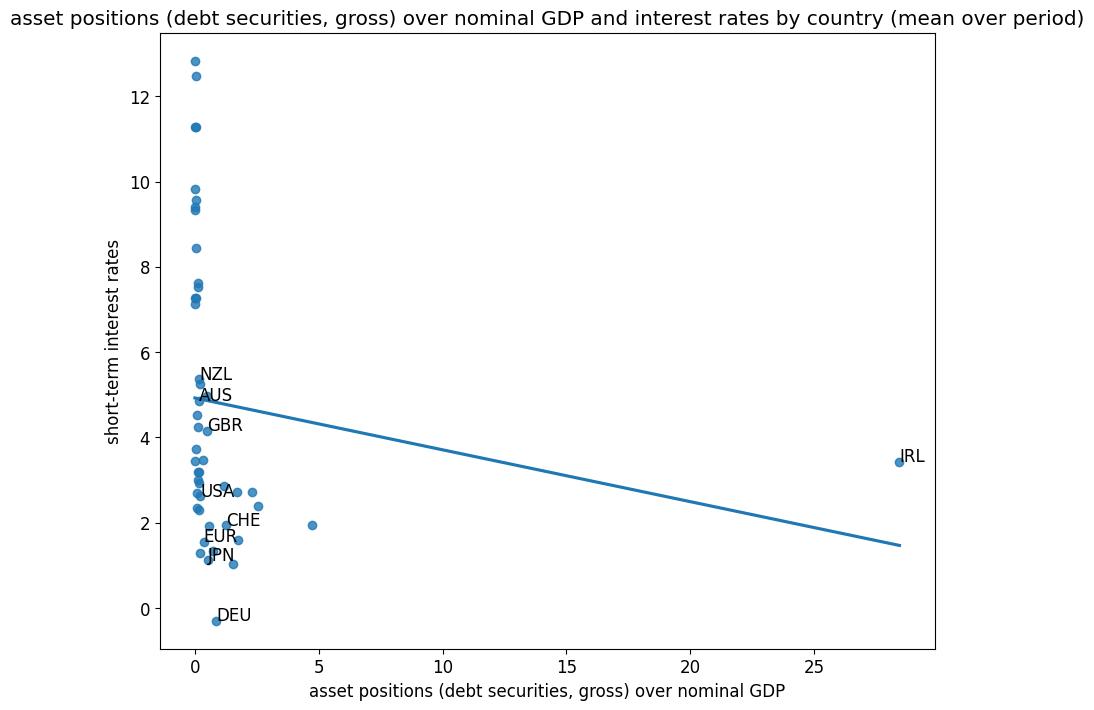

In [15]:
# scatterplots

indicators = ['asset positions (gross)', 'asset positions (equity, gross)', 'asset positions (debt securities, gross)',
              'asset positions (net)', 'asset positions (equity, net)', 'asset positions (debt securities, net)',
              'asset positions (gross) over nominal GDP', 'asset positions (equity, gross) over nominal GDP', 'asset positions (debt securities, gross) over nominal GDP']

plt.rcParams.update({'font.size': 12})
for indicator in indicators:
    # open figure + axis
    fig = plt.subplots(figsize=(10,8))
    # plot
    ax = sns.regplot(x=item_a1[indicator],y=item_a1['shortterm'],ci=None)
    # set labels
    ax.set_xlabel(indicator)
    ax.set_ylabel('short-term interest rates')
    ax.set_title(indicator + ' and interest rates by country (mean over period)')

    # annotate points in axis
    for idx, row in item_a1.iterrows():
        if idx in ['USA', 'GBR', 'JPN', 'EUR', 'DEU', 'IRL', 'CHE', 'AUS', 'NZL']:
            ax.annotate(idx, (row[indicator], row['shortterm']) )

b. Do you see big changes in these asset positions around either big risk off dates or when the VIX spikes/Global financial cycle is low? Do the countries with the international largest asset positions have the largest capital inflows in risk off periods?

i. 1997 Asia Crisis: 1997-06-30 (1997Q2) to 1997-12-31 (1997Q4)

ii.	2008 Financial Crisis: 2007-12-31 (2007Q4) to 2009-06-30 (2009Q2)

iii. 2010 Euro Sovereign Debt Crisis: 2009-10-31 (2009Q3) to 2010-12-31 (2010Q4)

iv.	2013 Taper Tantrum: 2013-06-30 (2013Q2) to 2013-12-31 (2013Q4)

v. Brexit referendum: 2016-06-30 (2016Q2) to 2016-10-31 (2016Q3)

vi. Brexit beginning: 2020-03-31 (2020Q1)

vii. COVID: 2020-03-31 (2020Q2) to 2021-03-31 ish (2021Q1)

In [18]:
# just look at some time series
# make a few of these for the countries i want to look at or loop through all the countries in the data
# loop through indicators, loop through countries, and then

# united states
us = iip_usd_long[(iip_usd_long['Indicator Code'].isin(['IA_BP6_USD', 
                                                'IL_BP6_USD', 
                                                'ILPE_BP6_USD', 
                                                'ILPD_BP6_USD', 
                                                'IAPE_BP6_USD', 
                                                'IAPD_BP6_USD'])) & (iip_usd_long['iso3'] == 'USA')][['Indicator Code', 'date', 'value']]

# japan
jp = iip_usd_long[(iip_usd_long['Indicator Code'].isin(['IA_BP6_USD', 
                                                'IL_BP6_USD', 
                                                'ILPE_BP6_USD', 
                                                'ILPD_BP6_USD', 
                                                'IAPE_BP6_USD', 
                                                'IAPD_BP6_USD'])) & (iip_usd_long['iso3'] == 'JPN')][['Indicator Code', 'date', 'value']]

TypeError: fill_between() missing 1 required positional argument: 'y1'

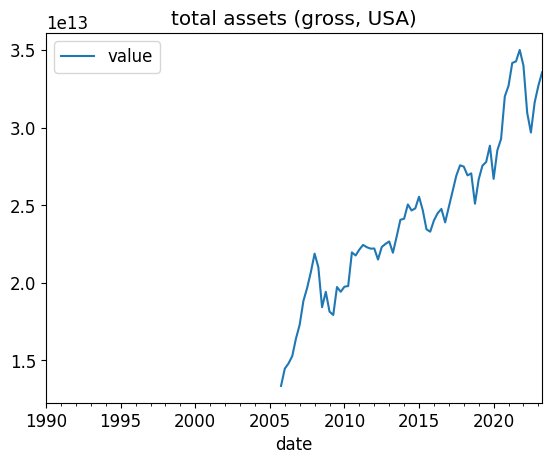

In [19]:
plt.rcParams.update({'font.size': 12})

us[us['Indicator Code'] == 'IA_BP6_USD'].plot(x='date', y='value')
plt.title('total assets (gross, USA)')
# Iterate through riskoff_dates and plot shaded regions
for index, row in riskoff_dates.iterrows():
    plt.axvspan(row['start'], row['end'], color=row['colour'], alpha=0.3, label=row['event'])


jp[jp['Indicator Code'] == 'IA_BP6_USD'].plot(x='date', y='value')
plt.title('total assets (gross, JPN)')